# Классификатор новостей на основе категорий yandex news

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers.core import Dense, Activation,Flatten
from keras import optimizers
from keras.preprocessing import sequence
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout 
import pandas as pd
from stop_words import get_stop_words

np.random.seed(5) 

Using TensorFlow backend.


In [2]:
file_data = './data_sets/ya_posts_category.csv'

In [3]:
names=['id','text','category','auto','in_world','culture','saince','social','polit','accidents','sport','tehnology','economica']
df = pd.read_csv(file_data, names=names)
 

### Удаляем стоп слова

In [4]:
stop_words = get_stop_words('ru')

def filter_stop_words(text):
    global stop_words
    new_sent = [word for word in text.split() if word not in stop_words] 
    return ' '.join(new_sent)  
    
texts =  df['text'].map(filter_stop_words)
Y =  df[names[3:]].values

In [27]:
df.sample(3)

,id,text,category,auto,in_world,culture,saince,social,polit,accidents,sport,tehnology,economica
7793,1149893,лондон февраля премию в номинации лучший фил...,Культура,0,0,1,0,0,0,0,0,0,0
3388,429906,президент соединенных штатов дональд трамп соо...,Политика,0,0,0,0,0,1,0,0,0,0
7389,431099,с наступлением весны в автомобиле нужно провер...,Авто,1,0,0,0,0,0,0,0,0,0


### Разбиваем на тестовую и обучающею выборку

разюиваем корпус данных и обучаемся. Далее обрезаем все тексты до 150 слов.

In [6]:
nb_words = 25000
tokenizer = Tokenizer(num_words=nb_words)
tokenizer.fit_on_texts( texts ) 

X_raw = tokenizer.texts_to_sequences(texts)
X = sequence.pad_sequences(X_raw, maxlen=150)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=33)

### Вначале обучим модель на основе рекурентного слоя LSTM 

- слой LSTM 100
- полносвязный слой 100
- выход 10 классов

In [7]:
learning_rate = 0.005

model = Sequential()
model.add(Embedding(nb_words, 100, input_length= X_train.shape[1]))
model.add(LSTM(100))
model.add(Dropout(0.5))
 
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
 
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

print( model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
__________

Обучаем 10 эпох и валидируем на тестовой выборке

In [8]:
epochs_len = 6

result = model.fit(X_train, Y_train,
          epochs=epochs_len, 
          verbose=1, shuffle=True,
          callbacks=[],          
          validation_data=(X_test, Y_test),     
          )

Train on 7800 samples, validate on 1950 samples
Epoch 1/6
7800/7800 [==============================] - 64s 8ms/step - loss: 1.2485 - acc: 0.5710 - val_loss: 0.6681 - val_acc: 0.7364
Epoch 2/6
7800/7800 [==============================] - 63s 8ms/step - loss: 0.4230 - acc: 0.8637 - val_loss: 0.4486 - val_acc: 0.8523
Epoch 3/6
7800/7800 [==============================] - 53s 7ms/step - loss: 0.2456 - acc: 0.9268 - val_loss: 0.4439 - val_acc: 0.8790
Epoch 4/6
7800/7800 [==============================] - 57s 7ms/step - loss: 0.1792 - acc: 0.9491 - val_loss: 0.4706 - val_acc: 0.8882
Epoch 5/6
7800/7800 [==============================] - 53s 7ms/step - loss: 0.1434 - acc: 0.9515 - val_loss: 0.6234 - val_acc: 0.8733
Epoch 6/6
7800/7800 [==============================] - 50s 6ms/step - loss: 0.1825 - acc: 0.9431 - val_loss: 0.6432 - val_acc: 0.8785


In [9]:
score = model.evaluate(X_test, Y_test, verbose=1)  
print ("Ошибка на тесте:  %f, точность на тесте: %f" % (score[0], score[1] ))

1950/1950 [==============================] - 3s 1ms/step
Ошибка на тесте:  0.643157, точность на тесте: 0.878462


Populating the interactive namespace from numpy and matplotlib


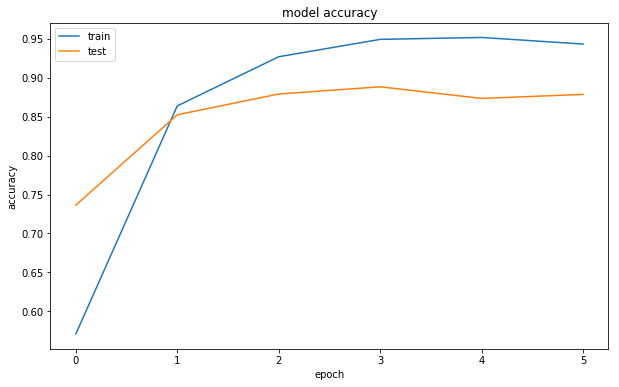

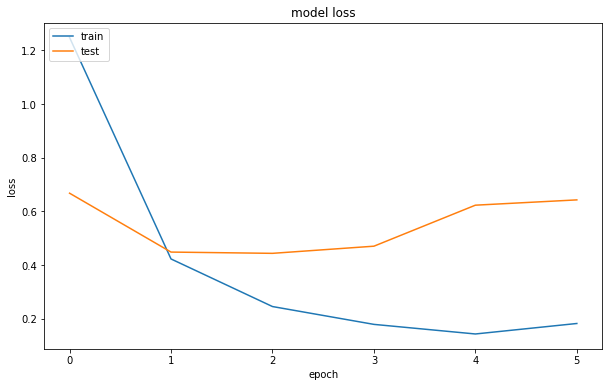

In [10]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Из графиков видно, что ошибка на 3 эпохе стала рости. 
- Точность на 3 эпохе вышла на константу

### Скомбинируем  модель на основе рекурентного слоя LSTM и сверточного Conv1D (одномерный слой свертки)


- сверточный слой 32
- слой LSTM 100
- выход 10 классов

In [11]:
from keras.layers import Conv1D,MaxPooling1D

learning_rate = 0.005

model2 = Sequential( )
model2.add(Embedding( nb_words, 100, input_length= X.shape[1]))
model2.add (Conv1D (filters = 32 , kernel_size = 3 , padding='same', activation = 'relu') )
model2.add (MaxPooling1D (pool_size = 2 ))
model2.add(LSTM (100)) 
model2.add(Dense(10))
model2.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"]) 
print (model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 2,563,842
Trainable params: 2,563,842
Non-trainable params: 0
_________________________________________________________________


Обучаем 10 эпох и валидируем на тестовой выборке

In [12]:
epochs_len = 6

result2 = model2.fit(X_train, Y_train,
          epochs=epochs_len, 
          verbose=1, shuffle=True,
          callbacks=[],          
          validation_data=(X_test, Y_test),     
          )

Train on 7800 samples, validate on 1950 samples
Epoch 1/6
7800/7800 [==============================] - 35s 4ms/step - loss: 0.8935 - acc: 0.6806 - val_loss: 0.3811 - val_acc: 0.8656
Epoch 2/6
7800/7800 [==============================] - 31s 4ms/step - loss: 0.2426 - acc: 0.9233 - val_loss: 0.3022 - val_acc: 0.9087
Epoch 3/6
7800/7800 [==============================] - 29s 4ms/step - loss: 0.1600 - acc: 0.9513 - val_loss: 0.3652 - val_acc: 0.8938
Epoch 4/6
7800/7800 [==============================] - 26s 3ms/step - loss: 0.1281 - acc: 0.9547 - val_loss: 0.3068 - val_acc: 0.9149
Epoch 5/6
7800/7800 [==============================] - 29s 4ms/step - loss: 0.1028 - acc: 0.9610 - val_loss: 0.3139 - val_acc: 0.9128
Epoch 6/6
7800/7800 [==============================] - 30s 4ms/step - loss: 0.0989 - acc: 0.9615 - val_loss: 0.3089 - val_acc: 0.9190


In [19]:
score = model2.evaluate(X_test, Y_test, verbose=1)  
print ("Ошибка на тесте:  %f, точность на тесте: %f" % (score[0], score[1] ))

1950/1950 [==============================] - 2s 805us/step
Ошибка на тесте:  0.308876, точность на тесте: 0.918974


Populating the interactive namespace from numpy and matplotlib


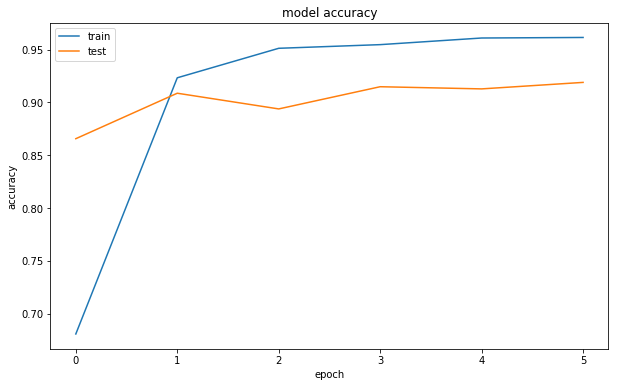

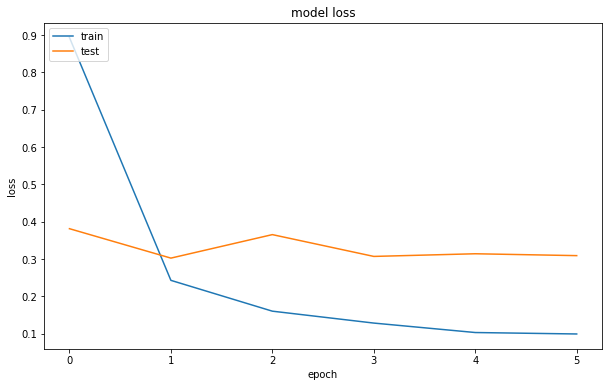

In [14]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# summarize history for accuracy
plt.plot(result2.history['acc'])
plt.plot(result2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result2.history['loss'])
plt.plot(result2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

- Из графиков видно, что ошибка на 3 эпохе стала рости. 
- Точность на 3 эпохе вышла на константу

### Скомбинируем  модель на основе полносвязных слоев


- полносвязный слой 100
- полносвязный слой 100
- выход 10 классов

In [15]:
learning_rate = 0.005

model3 = Sequential()
model3.add(Embedding(nb_words, 100, input_length= X_train.shape[1]))
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
 
model3.add(Dense(100))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Flatten())
    
model3.add(Dense(10))
model3.add(Activation('softmax'))

sgd = optimizers.Adam(lr=learning_rate)
model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

print( model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
dense_4 (Dense)              (None, 150, 100)          10100     
_________________________________________________________________
activation_4 (Activation)    (None, 150, 100)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 150, 100)          10100     
_________________________________________________________________
activation_5 (Activation)    (None, 150, 100)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 100)          0         
__________

In [16]:
epochs_len = 6 
 
result3 = model3.fit(X_train, Y_train,
           epochs=epochs_len, 
           verbose=1, shuffle=True,
           callbacks=[],  validation_data=(X_test, Y_test) 
    )

Train on 7800 samples, validate on 1950 samples
Epoch 1/6
7800/7800 [==============================] - 16s 2ms/step - loss: 1.3641 - acc: 0.5253 - val_loss: 0.6332 - val_acc: 0.7841
Epoch 2/6
7800/7800 [==============================] - 15s 2ms/step - loss: 0.5526 - acc: 0.8415 - val_loss: 0.4828 - val_acc: 0.8574
Epoch 3/6
7800/7800 [==============================] - 17s 2ms/step - loss: 0.3891 - acc: 0.8969 - val_loss: 0.4367 - val_acc: 0.8764
Epoch 4/6
7800/7800 [==============================] - 14s 2ms/step - loss: 0.3397 - acc: 0.9114 - val_loss: 0.5446 - val_acc: 0.8421
Epoch 5/6
7800/7800 [==============================] - 14s 2ms/step - loss: 0.3376 - acc: 0.9103 - val_loss: 0.4246 - val_acc: 0.8785
Epoch 6/6
7800/7800 [==============================] - 15s 2ms/step - loss: 0.3162 - acc: 0.9196 - val_loss: 0.3988 - val_acc: 0.8954


In [17]:
score = model3.evaluate(X_test, Y_test, verbose=1)  
print ("Ошибка на тесте:  %f, точность на тесте: %f" % (score[0], score[1] ))

1950/1950 [==============================] - 1s 313us/step
Ошибка на тесте:  0.398850, точность на тесте: 0.895385


Populating the interactive namespace from numpy and matplotlib


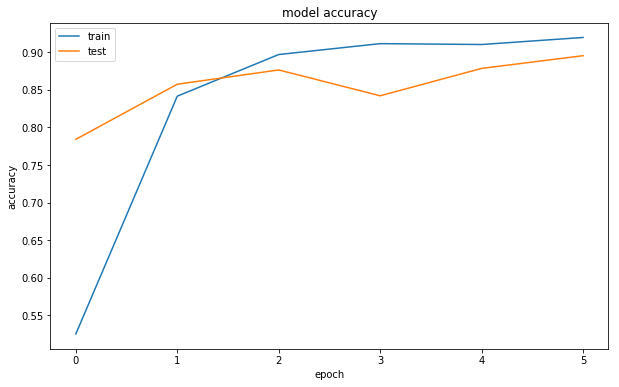

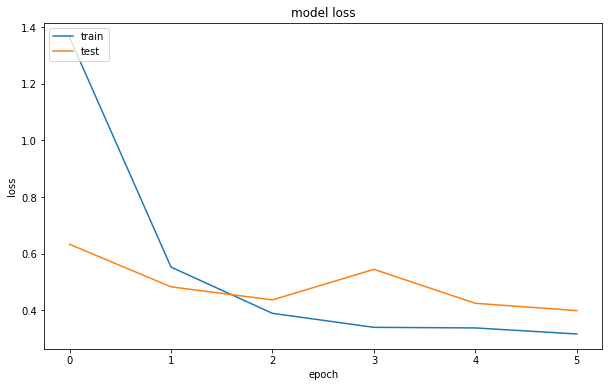

In [18]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# summarize history for accuracy
plt.plot(result3.history['acc'])
plt.plot(result3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result3.history['loss'])
plt.plot(result3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
text = 'Поездки в Грузию остаются безопасными, несмотря на сообщения в средствах массовой информации о недавних демонстрациях. Правительство Грузии принимает меры предосторожности для обеспечения безопасности путешественников в Тбилиси и по всей стране», — уверяют в ведомстве. Также отмечается, что все туристические направления и достопримечательности открыты для посещения, транспорт работает без перебоев.'
sample = tokenizer.texts_to_sequences([filter_stop_words(text)])
sample = sequence.pad_sequences(sample, maxlen=150)


In [24]:
print(model3.predict(sample))

[[0.00299656 0.10368408 0.01491923 0.0776405  0.47395033 0.18951851
  0.06047495 0.00171538 0.03909621 0.03600438]]


In [36]:
text2 = 'Нападающий Джек Хьюз выбран хоккейным клубом «Нью-Джерси Дэвилз» под первым номером в первом раунде драфта НХЛ-2019, проходящего в Ванкувере. Вторым в «Нью-Йорк Пейнджерс» был выбран финский форвард Каапо Какко, который в минувшем сезоне стал чемпионом мира по хоккею сразу в трех возрастных категориях. Третьим ушел в состав команды «Чикаго Блекхокс» нападающий Кирби Дич. Российский нападающий Василий Подколзин был задрафтован командой «Ванкувер Кэнакс» десятым Отметим 18-летний Хьюз стал первым и в итоговом рейтинге центрального бюро скаутов НХЛ среди игроков Канады и США. В прошедшем сезоне играл в Главной юниорской лиге США и набрал в 24 матчах 48 (12 шайб + 36 результативных передач) очков.'
sample2 = tokenizer.texts_to_sequences([filter_stop_words(text2)])
sample2 = sequence.pad_sequences(sample2, maxlen=150)


for i in sample2[0]:
    if i > 0:
        print( tokenizer.index_word[i])


нападающий
клубом
первым
номером
первом
раунде
нхл
вторым
форвард
минувшем
сезоне
чемпионом
хоккею
сразу
трех
категориях
третьим
ушел
состав
команды
нападающий
российский
нападающий
василий
командой
отметим
летний
первым
рейтинге
центрального
бюро
нхл
среди
игроков
канады
сша
в
сезоне
играл
главной
лиге
сша
набрал
матчах
результативных
передач
очков


In [41]:
print( np.round( model3.predict(sample2), 2) )

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
